# Homework 4

## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
### 1. Define a test problem in the following way:
* Let the user fix a positive integer $K > 0$, and define $θ{true} = (1, 1, . . . , 1)^T$ (you can also consider different $θ_{true}$);
* Define an input dataset $X = [x^1 x^2 . . . x^N ] ∈ R^N $, where the $ x^i $ are $N$ uniformly distributed datapoints in the interval $[a, b]$, where $a < b$ are values that the user can select;
* Given a set of functions ${φ_1,φ_2,...,φ_K}$, define the Generalized Vandermonde matrix $ Φ(X) ∈ R^{N×K}$, whose element in position $i,j$ is $φj(x^i)$. In particular, write a function defining the classical Vandermonde matrix where $φ_j(x) = x^{j−1}$;
* Given a variance $σ^2 > 0$ defined by the user, compute $Y = Φ(X)θ_{true} + e$, where $e ∼ N (0, σ^2I)$ is Gaussian distributed noise with variance $σ^2$. Try the following experiments for different values of $σ^2$. Note that the test problem defined in this way is very similar to what we did to define a test problem in the first Lab.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(0)

In [2]:
#defining function for classical Vandermonde matrix________________________________________________________________________
def Vander(x_, k_):
    result = np.ndarray((x_.shape[0], k_))          #R^(dxNxk)
    
    for i in range(k_):
        result[:,i] = x_**i                         #each column has x_ raised to the power of i (first column x_.T^0, second column x_.T^1, etc.)
    
    return result

In [3]:
def BuildDataset(N_, k_, a_, b_, var_):
    theta_true = np.ones(k_)                        #theta_true is a vector of ones of dimension kx1
    X = np.random.uniform(a_, b_, size=(N_,))       #uniform distribution of X going from a to b R^N
    
    e = np.random.normal(0, var_, N_)               #gaussian noise with mean 0 and variance var_, dimension N_
    Phi = Vander(X, k_)                             #Phi is the Vandermonde matrix of X, dimension Nxk
        
    Y = Phi @ theta_true + e

    return X, Y, Phi, theta_true

2. We now built a dataset D = {X,Y} such that θtrue = (1,1,...,1)T ∈ RK is the best solution to the least squares problem Φ(X)θ ≈ Y .


### 3. Pretend not to know the correct value of $K$. Try to guess it and use it to approximate the true solution $θ_{true}$ by MLE and MAP. To do that:
* Write a function that takes as input the training data $D = (X, Y )$ and $K$ and returns the MLE solution (with Gaussian assumption) $θ_{MLE} ∈ R^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.
* Write a function that takes as input a set of K-dimensional parameter vector $θ$ and a test set $\tau \epsilon = \{X_{test}, Y_{test}\}$ and returns the average absolute error of the polynomial regressor $f_θ(x)$ over $X_{test}$, computed as:

$$ \frac{1}{N_{test}} \|f_θ(X_{test}) − Y_{test}\|^2 $$

* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the learnt regression model $f_{θMLE} (x)$. Comment the results.
* For increasing values of $K$, use the functions defined above to compute the training and test error, where the test set is generated by sampling $N_{test}$ new points on the same interval [a,b] of the training set and generating the corresponding $Y_{test}$ with the same procedure of the training set. Plot the two errors with respect to $K$. Comment the results.
* Write a function that takes as input the training data $D = (X, Y )$, $K$ and $λ > 0$ and returns the MAP solution (with Gaussian assumption) $ θ_{MAP} ∈ R^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.
* For $K$ lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{θMAP} (x)$ with different values of $λ$. Comment the results.
* For $K$ being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of $λ$ (in the case of MAP).
* For $K$ greater than the true degree of the polynomial, define $Err(θ) = \frac{\|θ−θ_{true}\|_2}{\|θ_{true}\|_2}$ , where $θ_{true}$
has been padded with zeros to match the shape of $θ$. Compute $Err(θ_{MLE})$ and $Err(θ_{MAP} )$ for increasing values of $K$ and different values of $λ$.
* Compare the results obtained by increasing the number $N$ of datapoints.
* Compare the results obtained by the three algorithms GD, SGD and Normal Equations.
Note: when the value of a parameter is not explicitly specified, you can set it as you want. Suggestion: repeat for different values of the parameter.

##### 3.1 Write a function that takes as input the training data $D = (X, Y )$ and $K$ and returns the MLE solution (with Gaussian assumption) $θ_{MLE} ∈ R^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.

In [4]:
#if lamda not given, default value passed is 0 and will be for MLE____________________________________________________________________
def LossMAP(X_, Y_, theta_, lamda_=0):
    X, y, theta, lamda = X_, Y_, theta_, lamda_
    N = X_.shape[0]
    Phi = Vander(X, theta.shape[0])
    
    return 1/(2) * (Phi @ theta - y).T @ (Phi @ theta - y) + lamda/2 * theta.T @ theta

def GradLossMAP(X_, Y_, theta_, lamda_=0):
    X, y, theta, lamda = X_, Y_, theta_, lamda_
    N = X_.shape[0]
    Phi = Vander(X, theta.shape[0])
    
    return Phi.T @ (Phi @ theta - y) + lamda * theta

In [5]:
def Backtracking(f_, grad_f_, X_, y_, theta_):
    X, y, theta = X_, y_, theta_
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while (f_(X, y, (theta - alpha * np.mean(grad_f_(X, y, theta), axis = 1) )) > f_(X, y, theta) - c * alpha * np.linalg.norm(grad_f_(X, y, theta)) ** 2):
        alpha = tau * alpha
        
        if alpha < 1e-8:
            break
        
    return alpha

In [6]:
def GD(l_: object, grad_l_: object, w0_, data_, lamda_ = 0, kmax_ = 1000, toll_ = 0, tolx_ = 0, alpha_ = 1e-3, backtracking = False):
   
    X,y = data_                                                 #data is tuple
    
    k = 0                                                       #iteration counter
    w = [w0_]                                                   #array that contains the values of x_k at each iteration
    f_val = [l_(X, y, w0_, lamda_)]                             #contains the f function values at each iteration
    err = [np.linalg.norm(grad_l_(X, y, w0_, lamda_))]          #contains the value of ||grad_f(x_k)|| at each iteration
    grads = [grad_l_(X, y, w0_, lamda_)]                        #contains the value of grad_f(x_k) at each iteration
    
    condition = True
    condition3 = True                                           #for first iteration, condition3 is True
    while condition:
        condition1 = k < kmax_
        condition2 = np.linalg.norm(grads[-1]) > np.linalg.norm(toll_ * grad_l_(X, y, w0_, lamda_))
        if k != 0:
            condition3 = np.linalg.norm( np.array(w[-1]) - np.array(w[-2]) ) > tolx_    #w[-1] is w_k, w[-2] is w_k-1
        
        condition = (condition1 and condition2 and condition3)  #conditions for stopping the algorithm
                
        if backtracking:
            alpha = Backtracking(l_, grad_l_, X, y, w[-1])      #w[-1] is w_k
        else:                                                   #if backtracking=False, fixed alpha is used
            alpha = alpha_
        
        
        w_k1 = w[-1] - alpha * grads[-1]                         #update weight vector w_k+1
        
        l_k = l_(X, y, w_k1, lamda_)
        gradient_k = grad_l_(X, y, w_k1, lamda_)
        err_k = np.linalg.norm(gradient_k)
        
        w.append(w_k1)
        f_val.append(l_k)
        grads.append(gradient_k)
        err.append(err_k)
        
        k += 1
        
    return w, k, f_val, grads, err



def SGD(l_: object, grad_l_: object, w0_, data_, lamda_ = 0, batch_size_ = 10, n_epochs_ = 1000, alpha_ = 1e-3):
    
    X,y = data_                                                 #data is tuple
    
    w=[w0_]                                                     #initialized to initial iteration, contatins all w_k of different EPOCHS
    f_val=[l_( X, y, w[-1], lamda_)]                            #contains f(w_k) for each w_k
    grads=[grad_l_(X, y, w[-1], lamda_)]                        #contains gradient for each w_k
    err=[np.linalg.norm(grad_l_( X, y, w[-1], lamda_))]         #contains norm of gradient for each w_k

    
    num_batches = int(X.shape[0]/batch_size_)

    for epoch in range(0, n_epochs_):
        
        index=0                                                 #initialize index to 0 at the beginning of each epoch and add batch_size_ at each iteration over num_batches
        
        for batch in range(0,num_batches):
            
            if batch == num_batches-1:                          #if last batch, select all remaining data
                X_batch = X[index:-1]
                y_batch = y[index:-1]
                
            else:                                               #select data of batch_size
                X_batch = X[index:index+batch_size_]  
                y_batch = y[index:index+batch_size_]

   
            batch_gradient = grad_l_(X_batch, y_batch, w[-1], lamda_)
            w_k1 = w[-1] - alpha_ * batch_gradient
            w.append(w_k1)
            
            index = index + batch_size_                         #update index of batch_size for next batch
        
        
        mse_k = l_(X, y, w_k1, lamda_)                          #loss is defined as mean squared error of the whole dataset (not just the batch)
        gradient_k = grad_l_(X, y, w_k1, lamda_)
        err_k = np.linalg.norm(gradient_k)

        f_val.append(mse_k)
        grads.append(gradient_k)
        err.append(err_k)
    
    return w, f_val, grads, err


def NormalEquations(X_, y_, k_, lamda_ = 0):
    X, y, k, lamda = X_, y_, k_, lamda_
    Phi = Vander(X, k)
    
    return np.linalg.inv(Phi.T @ Phi + lamda * np.eye(k)) @ Phi.T @ y


In [7]:
k = 4
a = 0
b = 1
N = 100
var = 0.2   #variance, try with different values

X_train, Y_train, Phi_train, theta_true_train = BuildDataset(N, k, a, b, var)
print(f'Shape of X: {X_train.shape}, shape of Y: {Y_train.shape}, shape of Phi: {Phi_train.shape}, shape of theta_true: {theta_true_train.shape}')

X_test, Y_test, Phi_test, theta_true_test = BuildDataset(N, k, a, b, var)

Shape of X: (100,), shape of Y: (100,), shape of Phi: (100, 4), shape of theta_true: (4,)


In [8]:
theta_star_GD, _, _, _, _ = GD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train))
print(f'Optimal theta with GD: {theta_star_GD[-1]}')
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_GD[-1], lamda_=0)}')

Optimal theta with GD: [1.01013728 1.16473682 0.96572709 0.82685057]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 1.9521151843379485


In [9]:
theta_star_NE = NormalEquations(X_train, Y_train, k)
print(f'Optimal theta with Normal Equations: {theta_star_NE}')
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_NE, lamda_=0)}')

Optimal theta with Normal Equations: [ 0.96462298  1.65455922 -0.15255326  1.52305394]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 1.9422929113432215


In [10]:
theta_star_SGD, _, _, _ = SGD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train))
print(f'Optimal theta with SGD: {theta_star_SGD[-1]}')  
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_SGD[-1], lamda_=0)}')

Optimal theta with SGD: [1.00942469 1.16201288 0.96653923 0.82789094]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 1.9523217956943189


##### 3.2 Write a function that takes as input a set of K-dimensional parameter vector $θ$ and a test set $\tau \epsilon = \{X_{test}, Y_{test}\}$ and returns the average absolute error of the polynomial regressor $f_θ(x)$ over $X_{test}$, computed as:

$$ \frac{1}{N_{test}} \|f_θ(X_{test}) − Y_{test}\|^2 $$

In [11]:
def AverageError(X_, y_, theta_):
    X, y, theta = X_, y_, theta_
    N = X.shape[0]
    
    return ((np.linalg.norm(Vander(X, theta.shape[0]) @ theta - y, 2))**2)*(1/N)

##### 3.3 For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the learnt regression model $f_{θMLE} (x)$. Comment the results.
##### 3.4 For increasing values of $K$, use the functions defined above to compute the training and test error, where the test set is generated by sampling $N_{test}$ new points on the same interval [a,b] of the training set and generating the corresponding $Y_{test}$ with the same procedure of the training set. Plot the two errors with respect to $K$. Comment the results.

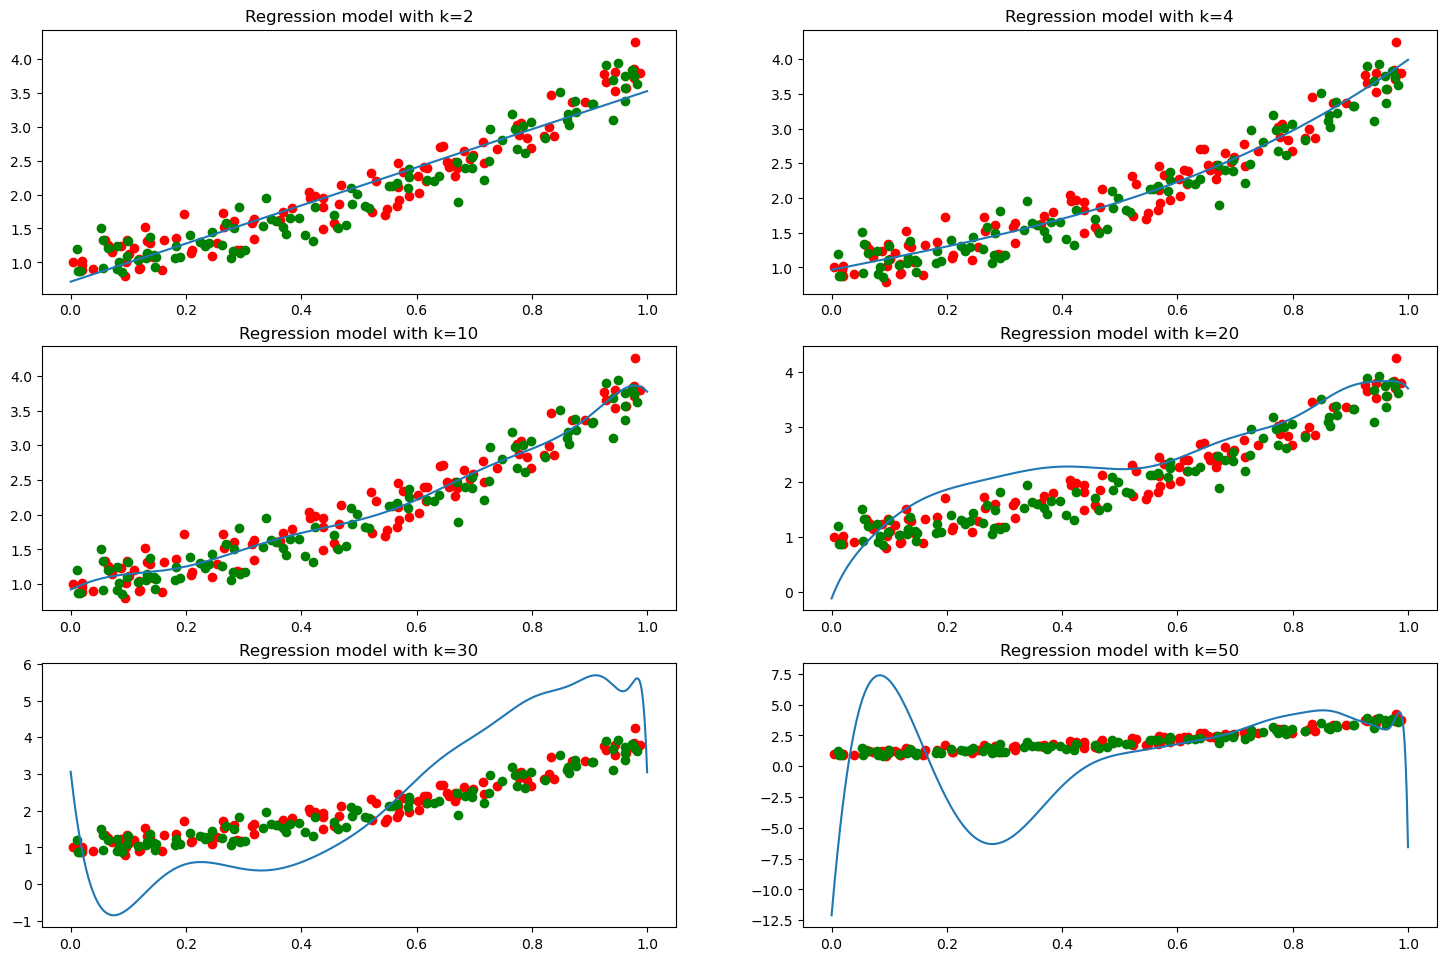

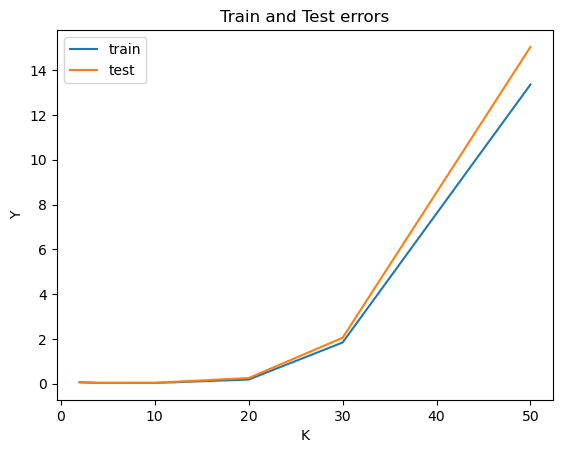

In [12]:
ks = [2, 4, 10, 20, 30, 50]      #different k than trayining set

i=0
plt.figure(figsize=(18, 24))
train_errors = []
test_errors = []
for k in ks:
    theta_star_NE = NormalEquations(X_train, Y_train, k)
    train_error = AverageError(X_train, Y_train, theta_star_NE)
    test_error = AverageError(X_test, Y_test, theta_star_NE)

    train_errors.append(train_error)
    test_errors.append(test_error)

    XX = np.linspace(a, b, 1000)
    YY = Vander(XX, k) @ theta_star_NE
    
    plt.subplot(len(ks), 2, i+1)
    i+=1
    plt.plot(X_train, Y_train, 'ro')
    plt.plot(X_test, Y_test, 'go')
    plt.plot(XX, YY)
    plt.title(f'Regression model with k={k}')
    
plt.show()


plt.plot(ks, train_errors)
plt.plot(ks, test_errors)
plt.plot()
plt.title('Train and Test errors')
plt.xlabel('K')
plt.ylabel('Y')
plt.legend(['train', 'test'])
plt.show()


Train and Test errors with GD

## MAP

##### 3.5 Write a function that takes as input the training data $D = (X, Y )$, $K$ and $λ > 0$ and returns the MAP solution (with Gaussian assumption) $ θ_{MAP} ∈ R^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.

In [14]:
k = 4
a = 0
b = 1
N = 100
var = 0.1   #variance, try with different values

X_train, Y_train, Phi_train, theta_true_train = BuildDataset(N, k, a, b, var)
print(f'Shape of X: {X_train.shape}, shape of Y: {Y_train.shape}, shape of Phi: {Phi_train.shape}, shape of theta_true: {theta_true_train.shape}')

X_test, Y_test, Phi_test, theta_true_test = BuildDataset(N, k, a, b, var)

Shape of X: (100,), shape of Y: (100,), shape of Phi: (100, 4), shape of theta_true: (4,)


In [15]:
theta_star_GD, _, _, _, _ = GD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train), lamda_=0.1)
print(f'Optimal theta with GD: {theta_star_GD[-1]}')
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_GD[-1], lamda_=0.1)}')

Optimal theta with GD: [0.9871691  1.03436185 1.01023936 0.93634353]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 0.7824071853447991


In [16]:
theta_star_SGD, _, _, _ = SGD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train), lamda_=0.1)
print(f'Optimal theta with SGD: {theta_star_SGD[-1]}')  
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_SGD[-1], lamda_=0.1)}')

Optimal theta with SGD: [0.9964291  1.03776616 0.98065692 0.89467263]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 0.8078848613384908


In [17]:
theta_star_SGD, _, _, _ = SGD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train),lamda_=0.1)
print(f'Optimal theta with SGD: {theta_star_SGD[-1]}')  
print(f'True theta: {theta_true_train}')
print(f'Loss of optimal theta: {LossMAP(X_train, Y_train, theta_star_SGD[-1], lamda_=0.1)}')

Optimal theta with SGD: [0.9964291  1.03776616 0.98065692 0.89467263]
True theta: [1. 1. 1. 1.]
Loss of optimal theta: 0.8078848613384908


##### 3.6 For $K$ lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{θMAP} (x)$ with different values of $λ$. Comment the results.

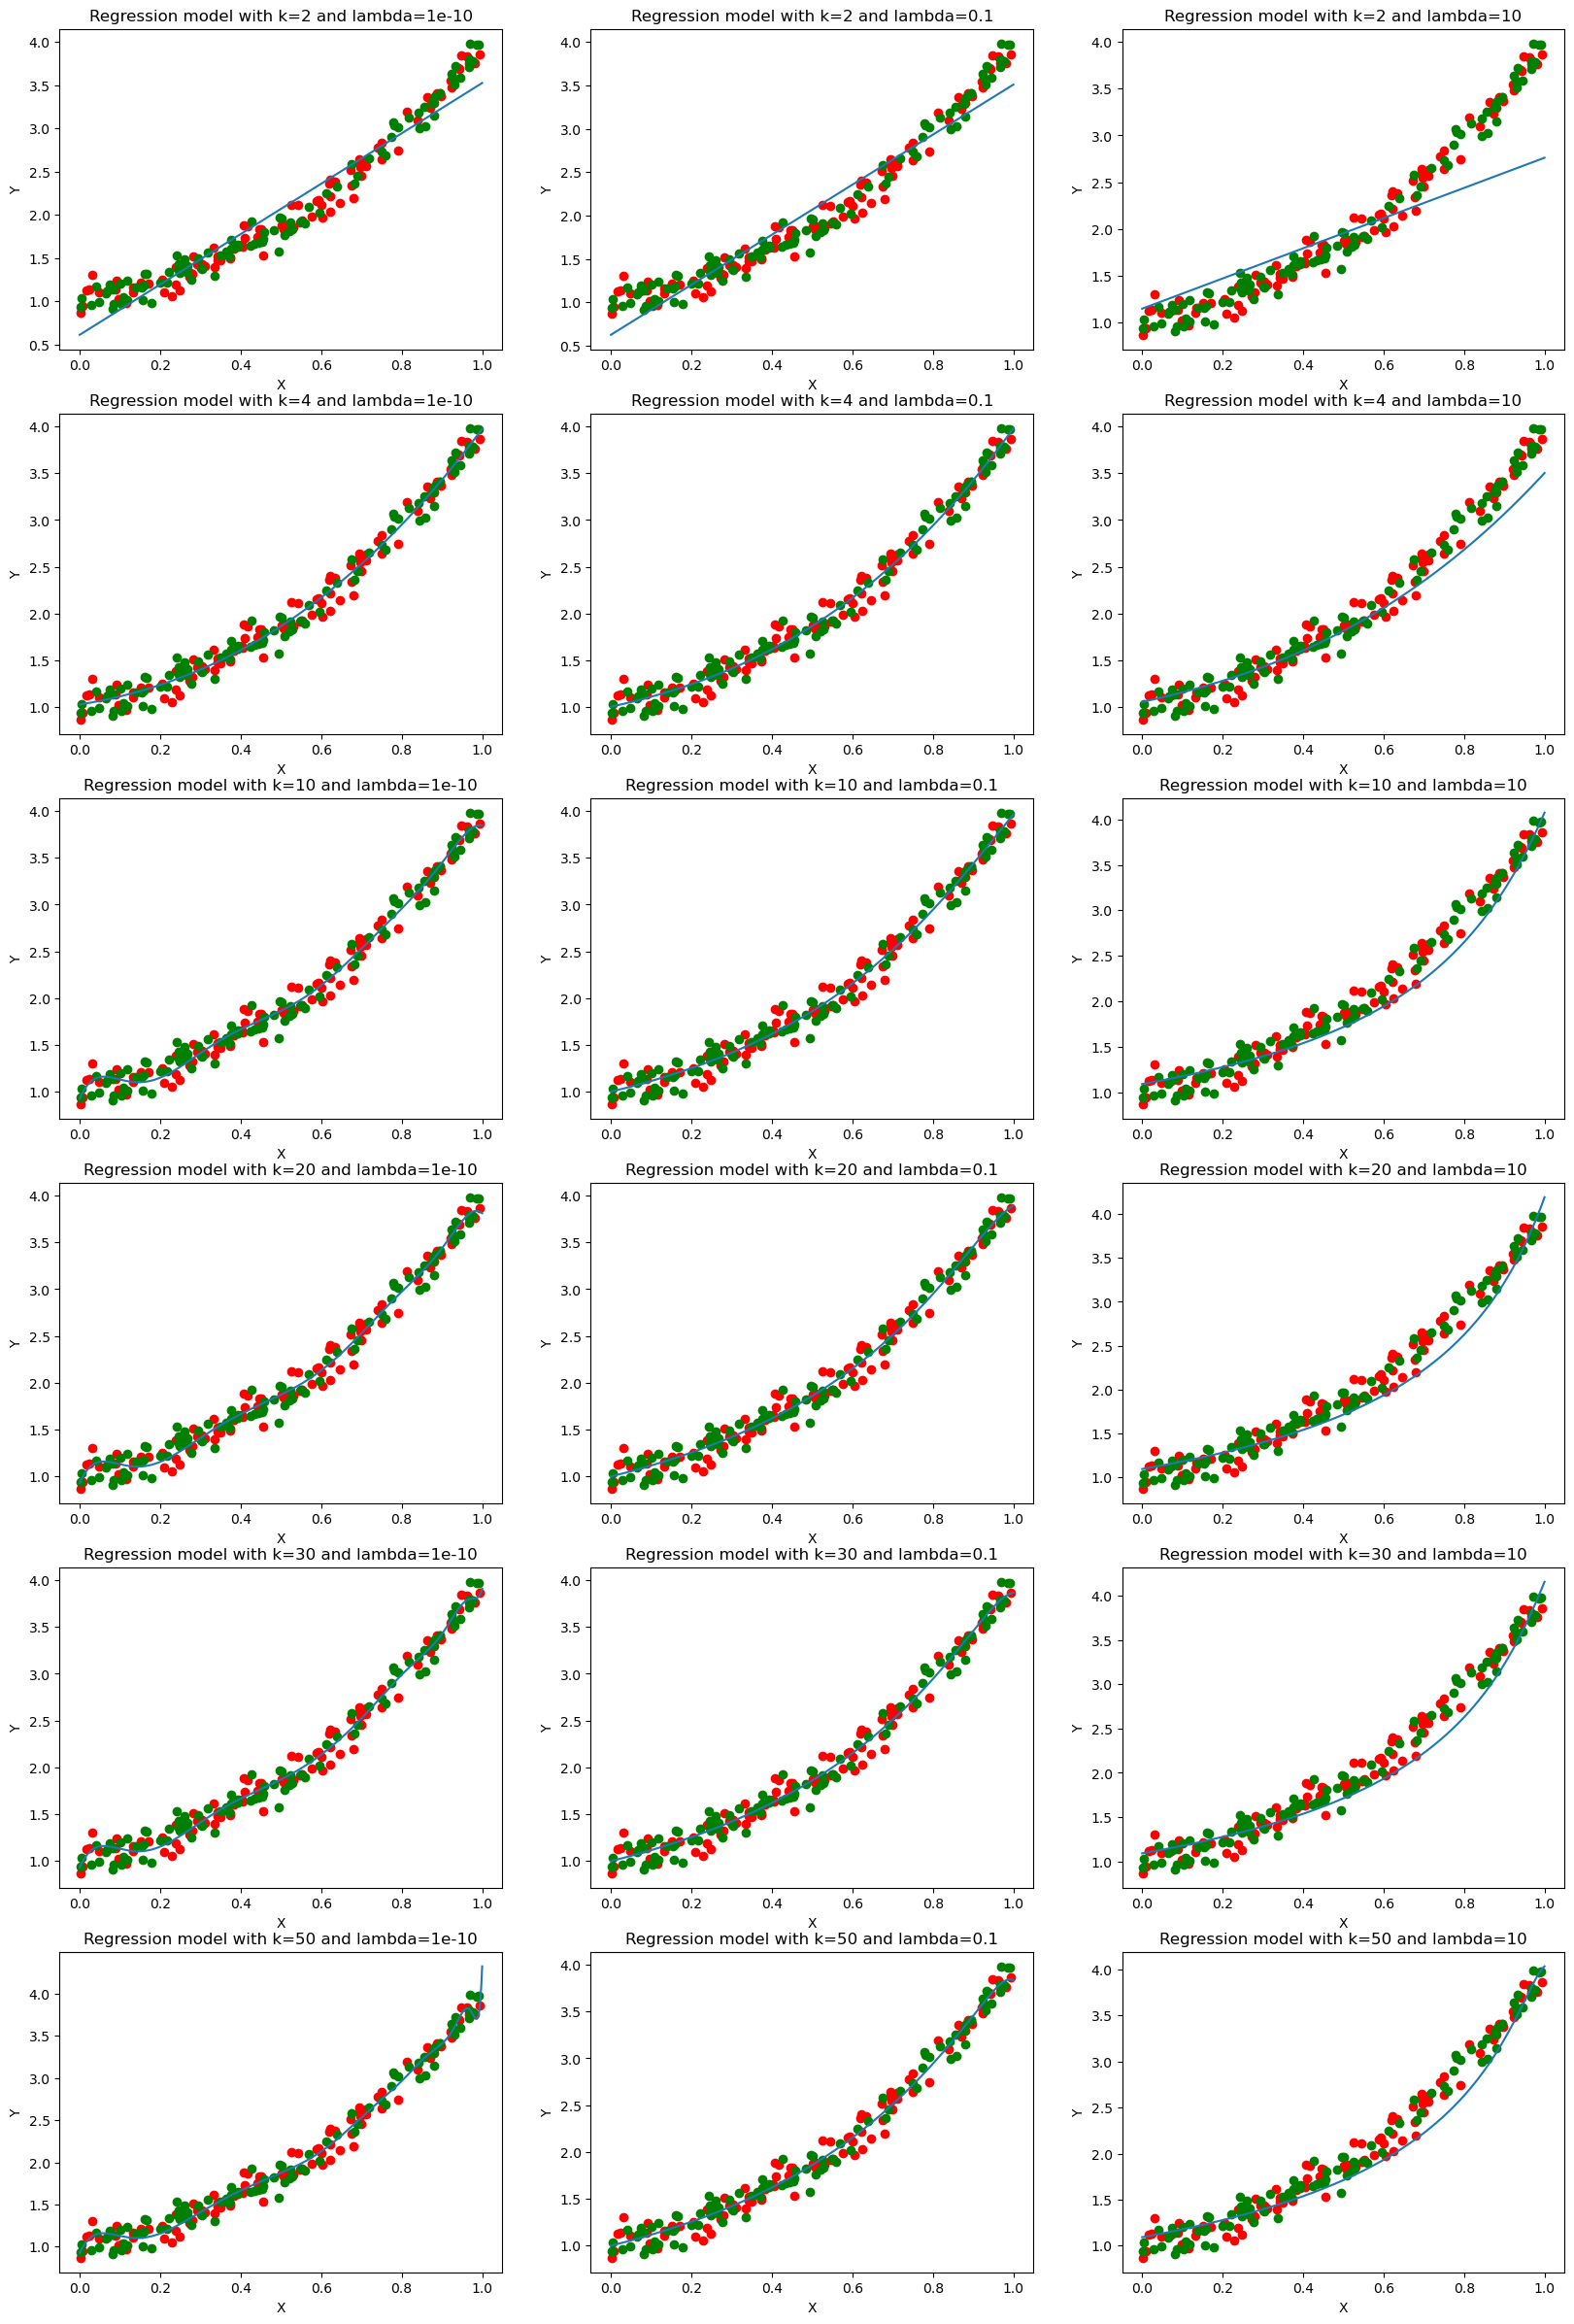

In [18]:
KS=[2,4,10,20,30,50]
Lamdas=[1e-10, 1e-1, 10]

train_errors=[]
test_errors=[]

plt.figure(figsize=(20, 30))

i = 1
for k in KS:
    for lamda in Lamdas:
        
        theta_star_NE = NormalEquations(X_train, Y_train, k, lamda)

        train_error = AverageError(X_train, Y_train, theta_star_NE)         #calculate average error passing calculated optimal theta
        test_error = AverageError(X_test, Y_test, theta_star_NE)
        train_errors.append(train_error)
        test_errors.append(test_error)
        
        XX = np.linspace(a, b, 1000)
        YY = Vander(XX, k) @ theta_star_NE                                 #calculate YY passing calculated optimal theta
        
        plt.subplot(len(KS), len(Lamdas), i)
        i+=1
        
        plt.plot(X_train, Y_train, 'ro')
        plt.plot(X_test, Y_test, 'go')
        plt.plot(XX, YY)
        plt.plot()
        plt.title(f'Regression model with k={k} and lambda={lamda}')
        plt.xlabel('X')
        plt.ylabel('Y')
    
plt.show()

##### 3.7 For $K$ being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of $λ$ (in the case of MAP).
##### 3.8 For $K$ greater than the true degree of the polynomial, define $Err(θ) = \frac{\|θ−θ_{true}\|_2}{\|θ_{true}\|_2}$ , where $θ_{true}$ has been padded with zeros to match the shape of $θ$. Compute $Err(θ_{MLE})$ and $Err(θ_{MAP} )$ for increasing values of $K$ and different values of $λ$.

In [19]:
def ThetaError(theta_star_, theta_true_):
    theta_star, theta_true = theta_star_, theta_true_
    theta_true = np.pad(theta_true, (0, theta_star.shape[0] - theta_true.shape[0]), mode='constant')
    
    err = np.linalg.norm(theta_star - theta_true, 2)/np.linalg.norm(theta_true, 2)
    
    return err



k = 10, lamda = 1e-10
Error from true theta MAP = 3059.921749639634
Error from true theta MLE = 5602.626465482456
Train error MAP = 0.009975078051790914
Train error MLE = 0.009965728158696037
Test error MAP = 0.012478376759689503
Test error MLE = 0.01263753152501841

k = 15, lamda = 1e-10
Error from true theta MAP = 2998.422702809509
Error from true theta MLE = 1395440.647593799
Train error MAP = 0.009935985090489667
Train error MLE = 0.2505367857023769
Test error MAP = 0.012334143709439794
Test error MLE = 0.2594033518398091

k = 20, lamda = 1e-10
Error from true theta MAP = 3415.7714142672635
Error from true theta MLE = 941609.260310176
Train error MAP = 0.009910821760248661
Train error MLE = 0.04341935232549807
Test error MAP = 0.012307852131762852
Test error MLE = 0.04394527973614936

k = 30, lamda = 1e-10
Error from true theta MAP = 3059.407662072086
Error from true theta MLE = 3119194.611070905
Train error MAP = 0.009871151869269961
Train error MLE = 0.1549013512173334
Test error

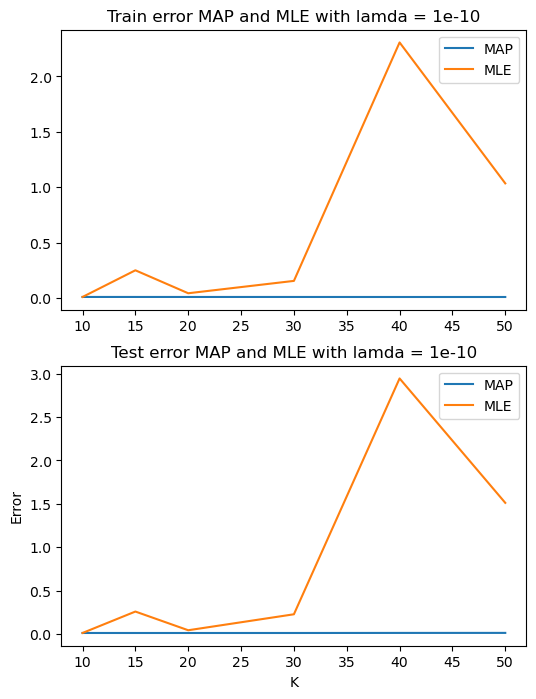

k = 10, lamda = 0.1
Error from true theta MAP = 0.3150772877984958
Error from true theta MLE = 5602.626465482456
Train error MAP = 0.011604121165963802
Train error MLE = 0.009965728158696037
Test error MAP = 0.0105801454549261
Test error MLE = 0.01263753152501841

k = 15, lamda = 0.1
Error from true theta MAP = 0.3207554376365722
Error from true theta MLE = 1395440.647593799
Train error MAP = 0.011557790685407828
Train error MLE = 0.2505367857023769
Test error MAP = 0.01073078647420921
Test error MLE = 0.2594033518398091

k = 20, lamda = 0.1
Error from true theta MAP = 0.3088532848825164
Error from true theta MLE = 941609.260310176
Train error MAP = 0.011550487066518638
Train error MLE = 0.04341935232549807
Test error MAP = 0.0108471847428589
Test error MLE = 0.04394527973614936

k = 30, lamda = 0.1
Error from true theta MAP = 0.2994644834947128
Error from true theta MLE = 3119194.611070905
Train error MAP = 0.011535123208172824
Train error MLE = 0.1549013512173334
Test error MAP = 0.0

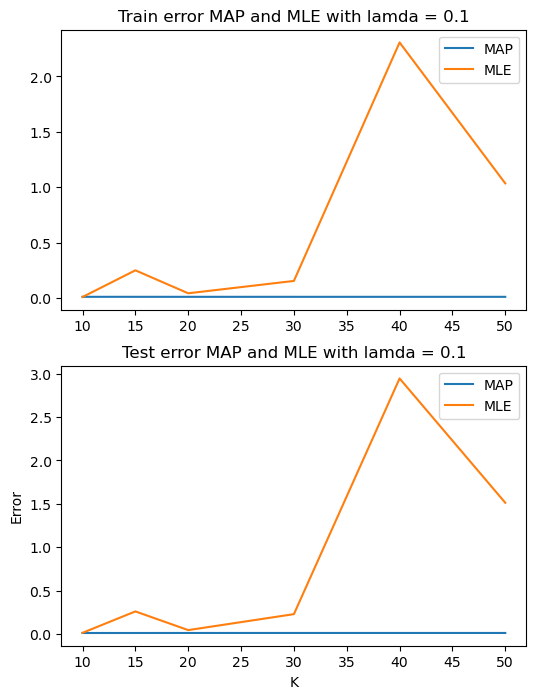

In [20]:
#k way greater than k of polynomial = 4
KS = [10, 15, 20, 30, 40, 50]
Lamdas=[1e-10, 1e-1]

for lamda in Lamdas:
    train_errors_MAP = []
    test_errors_MAP = []
    train_errors_MLE = []
    test_errors_MLE = []
    
    for k in KS:
        theta_star_MAP = NormalEquations(X_train, Y_train, k, lamda)
        theta_error_MAP = ThetaError(theta_star_MAP, theta_true_train)
        train_error_MAP = AverageError(X_train, Y_train, theta_star_MAP)
        test_error_MAP = AverageError(X_test, Y_test, theta_star_MAP)
        train_errors_MAP.append(train_error_MAP)
        test_errors_MAP.append(test_error_MAP)
        
        theta_star_MLE = NormalEquations(X_train, Y_train, k)
        theta_error_MLE = ThetaError(theta_star_MLE, theta_true_train)
        train_error_MLE = AverageError(X_train, Y_train, theta_star_MLE)
        test_error_MLE = AverageError(X_test, Y_test, theta_star_MLE)
        train_errors_MLE.append(train_error_MLE)
        test_errors_MLE.append(test_error_MLE)
        
        print(f'k = {k}, lamda = {lamda}')
        print(f'Error from true theta MAP = {theta_error_MAP}')
        print(f'Error from true theta MLE = {theta_error_MLE}')
        print(f'Train error MAP = {train_error_MAP}')
        print(f'Train error MLE = {train_error_MLE}')
        print(f'Test error MAP = {test_error_MAP}')
        print(f'Test error MLE = {test_error_MLE}\n')

    plt.figure(figsize=(6, 8))
    plt.subplot(2, 1, 1)
    plt.title(f'Train error MAP and MLE with lamda = {lamda}')
    plt.plot(KS, train_errors_MAP)
    plt.plot(KS, train_errors_MLE)
    plt.legend(['MAP', 'MLE'])
    
    plt.subplot(2, 1, 2)
    plt.title(f'Test error MAP and MLE with lamda = {lamda}')
    plt.plot(KS, test_errors_MAP)
    plt.plot(KS, test_errors_MLE)
    plt.legend(['MAP', 'MLE'])

    plt.xlabel('K')
    plt.ylabel('Error')

    
    plt.show()
    

        
        

* We can see from the printed results above that the relative error of Theta relates with the Average Absolute Error. In fact if theta is far from true theta, also $f_{\theta}(X)$ will be far from the expected result Y

##### 3.9 Compare the results obtained by increasing the number $N$ of datapoints.
##### 3.10 Compare the results obtained by the three algorithms GD, SGD and Normal Equations.

In [21]:
k = 4
a = 0
b = 1
N = 1000   #increasing N
var = 0.1   

X_train, Y_train, Phi_train, theta_true_train = BuildDataset(N, k, a, b, var)
print(f'Shape of X: {X_train.shape}, shape of Y: {Y_train.shape}, shape of Phi: {Phi_train.shape}, shape of theta_true: {theta_true_train.shape}')

X_test, Y_test, Phi_test, theta_true_test = BuildDataset(N, k, a, b, var)

Shape of X: (1000,), shape of Y: (1000,), shape of Phi: (1000, 4), shape of theta_true: (4,)


Loss of optimal theta Normal Equations: 4.6240814583117125

Loss of optimal theta GD: 4.655203931202828

Loss of optimal theta SGD: 4.625522030686724



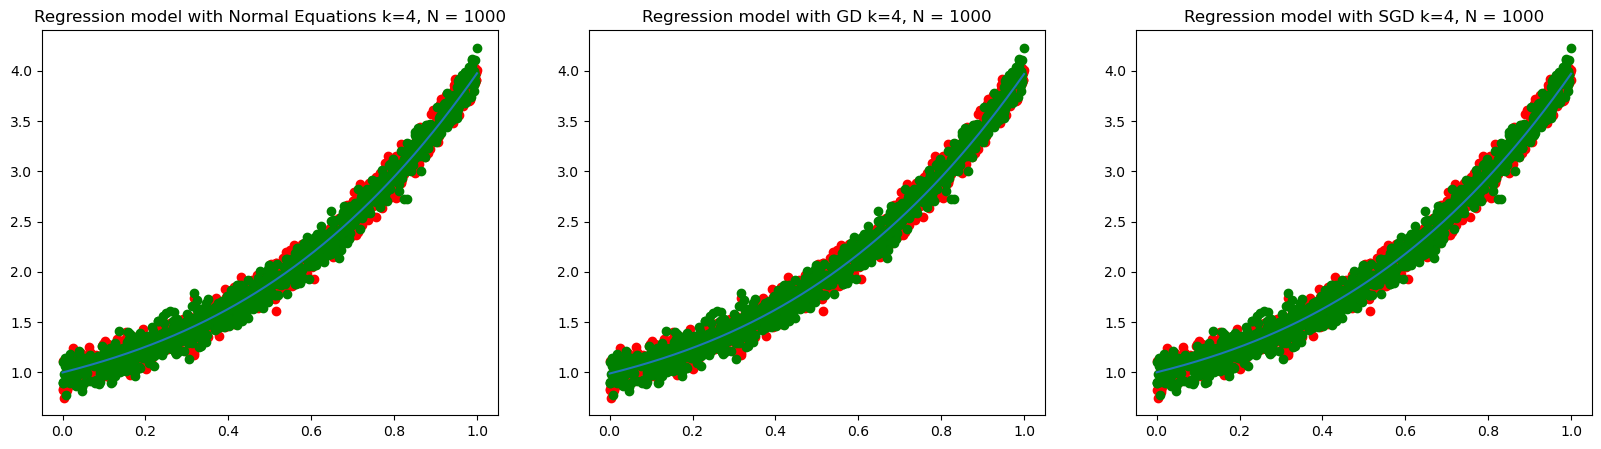

Loss of optimal theta Normal Equations: 4.583203056101784

Loss of optimal theta GD: 4.655203931202828

Loss of optimal theta SGD: 4.631430368430081



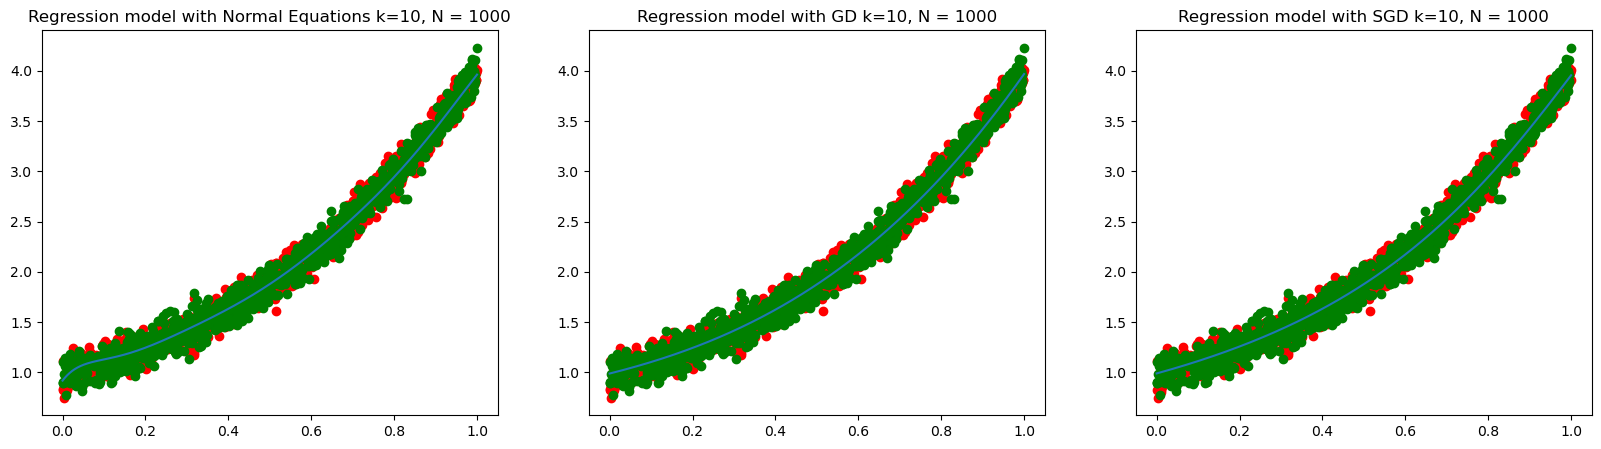

Loss of optimal theta Normal Equations: 7164.349336506643

Loss of optimal theta GD: 4.655203931202828

Loss of optimal theta SGD: 4.637441915473062



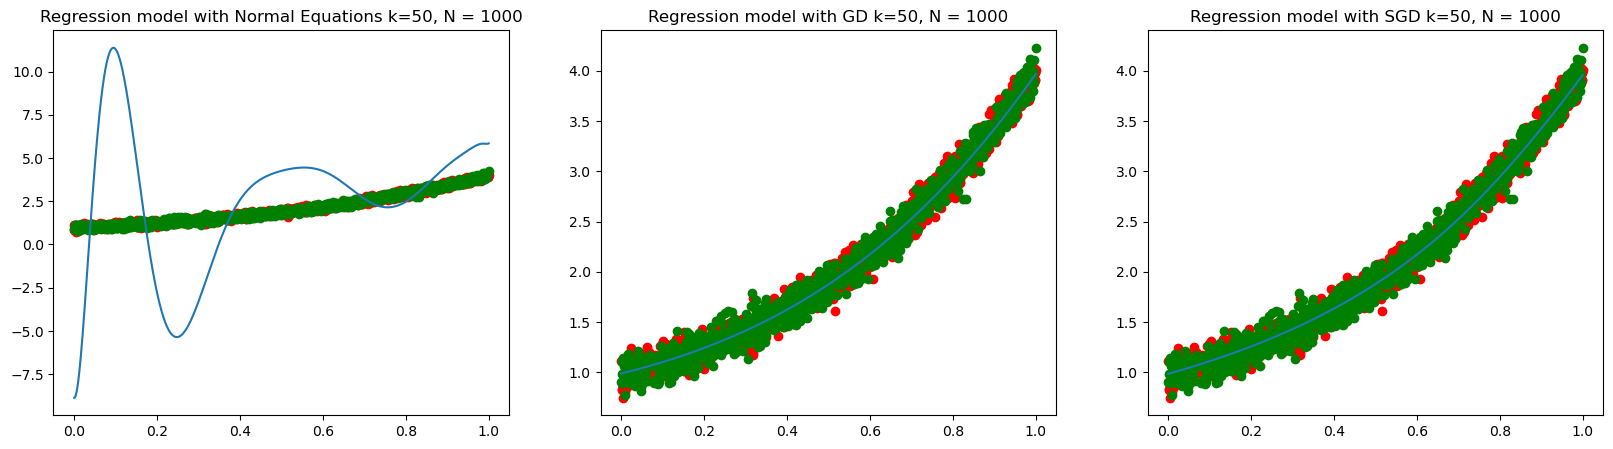

Loss of optimal theta Normal Equations: 3721793721327.1763



/var/folders/74/mfh_yx395gl1npjn4f386mpc0000gn/T/ipykernel_2625/3888630338.py:7: RuntimeWarning: overflow encountered in matmul
  return 1/(2) * (Phi @ theta - y).T @ (Phi @ theta - y) + lamda/2 * theta.T @ theta


Loss of optimal theta GD: 4.655203931202828

Loss of optimal theta SGD: 4.634848688626766



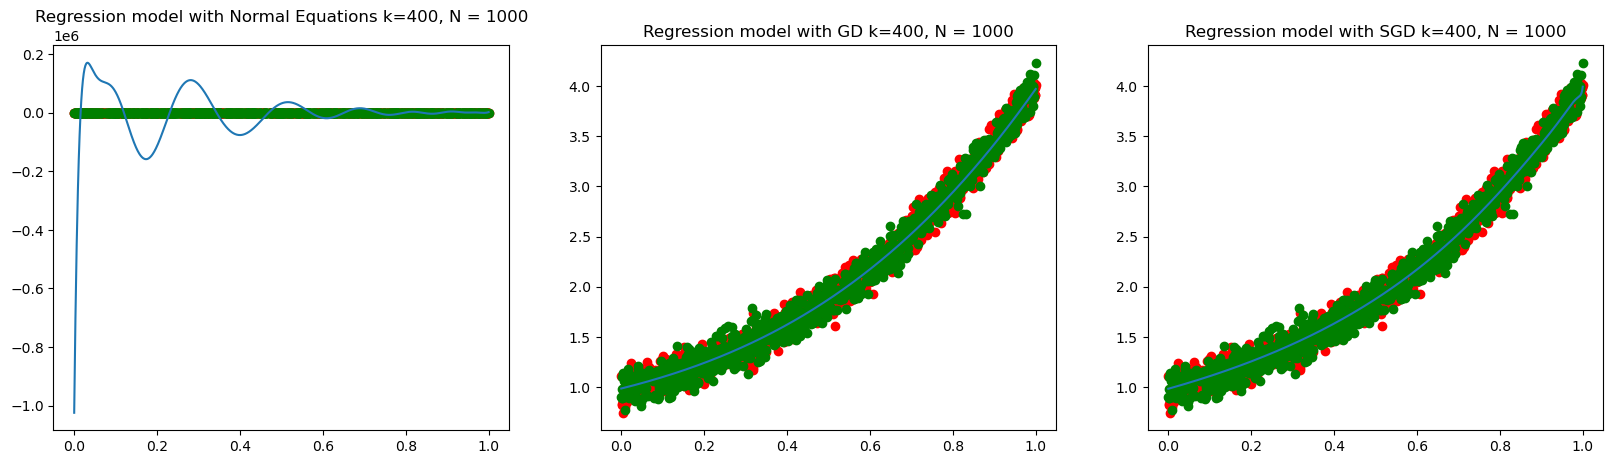

In [22]:
KS = [4, 10, 50, 400]

for k in KS:
    theta_star_NE = NormalEquations(X_train, Y_train, k)
    print(f'Loss of optimal theta Normal Equations: {LossMAP(X_train, Y_train, theta_star_NE, lamda_=0)}\n')
    
    thete_star_GD, _, _, _, _ = GD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train))
    print(f'Loss of optimal theta GD: {LossMAP(X_train, Y_train, theta_star_GD[-1], lamda_=0)}\n')
    
    theta_star_SGD, _, _, _ = SGD(LossMAP, GradLossMAP, w0_= np.zeros(k), data_=(X_train, Y_train))
    print(f'Loss of optimal theta SGD: {LossMAP(X_train, Y_train, theta_star_SGD[-1], lamda_=0)}\n')
    
    XX = np.linspace(a, b, 1000)
    YY_NE = Vander(XX, theta_star_NE.shape[0]) @ theta_star_NE
    YY_GD = Vander(XX, theta_star_GD[-1].shape[0]) @ theta_star_GD[-1]
    YY_SGD = Vander(XX, theta_star_SGD[-1].shape[0]) @ theta_star_SGD[-1]
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(X_train, Y_train, 'ro')
    plt.plot(X_test, Y_test, 'go')
    plt.plot(XX, YY_NE)
    plt.title(f'Regression model with Normal Equations k={k}, N = {N}')
    
    plt.subplot(1, 3, 2)
    plt.plot(X_train, Y_train, 'ro')
    plt.plot(X_test, Y_test, 'go')
    plt.plot(XX, YY_GD)
    plt.title(f'Regression model with GD k={k}, N = {N}')
    
    plt.subplot(1, 3, 3)
    plt.plot(X_train, Y_train, 'ro')
    plt.plot(X_test, Y_test, 'go')
    plt.plot(XX, YY_SGD)
    plt.title(f'Regression model with SGD k={k}, N = {N}')
    
    plt.show()
    

* With N higher the Normal Equations parameters estimation, seem to have higher edge to edge peaks.